In [2]:
import os
import glob
import scipy
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.io import savemat, loadmat
from sklearn import datasets, linear_model, preprocessing
from scipy.stats import probplot, pearsonr
from sklearn.preprocessing import scale,robust_scale
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

/Users/emilyhahn/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Configure environment

In [3]:
dACC_group=[]
L_dlPFC_group=[]
R_dlPFC_group=[]
L_IFG_group=[]
R_IFG_group=[]
conflict_group=[]
adapt_group=[]
rt_group=[]

dACC_group_hc=[]
L_dlPFC_group_hc=[]
R_dlPFC_group_hc=[]
L_IFG_group_hc=[]
R_IFG_group_hc=[]
conflict_group_hc=[]
adapt_group_hc=[]
rt_group_hc=[]

dACC_group_pts=[]
L_dlPFC_group_pts=[]
R_dlPFC_group_pts=[]
L_IFG_group_pts=[]
R_IFG_group_pts=[]
conflict_group_pts=[]
adapt_group_pts=[]
rt_group_pts=[]

regions=['dACC','L_dlPFC','R_dlPFC','L_IFG','R_IFG']
variables=['rt','adapt','conflict']
raw_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/msit_mri_behav'
preproc_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/completed'
LSS_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG'
LSS_estim_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG_estim'
censor_dir='/Users/emilyhahn/projects/msit_modeling/censor_data'

df=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_I=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_C=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})
df_I_C=pd.DataFrame({"group":[],"subject":[],'rt':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'acc':[],'conflict':[],'adapt':[]})

df_I_epoch_first45=pd.DataFrame({"group":[],"subject":[],'rt':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'acc':[],'conflict':[],'adapt':[]})
df_C_epoch_first45=pd.DataFrame({"group":[],"subject":[],'rt':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'acc':[],'conflict':[],'adapt':[]})

### Define Subjects

In [4]:
SUBJ_LIST = ['hc001','hc002','hc003','hc005','hc006','hc010','hc011','hc012','hc014',\
             'hc015','hc017','hc019','hc021','hc028','hc031','hc032','hc033','hc034',\
             'hc036','hc038','hc042','pp001','pp002','pp003','pp004','pp005','pp006',\
             'pp010','pp011','pp012','pp013','pp015','pp016']

# SUBJ_LIST = ['hc001','pp001']

### Define Functions - Data Structs

In [5]:
def remove_outliers(rt_var,RT_arr,sub):
    elements=[i for i in RT_arr]
    mean = np.nanmean(elements)
    sd = np.nanstd(elements)
    sd_lower = mean - 5 * sd
    sd_upper = mean + 5 * sd
    for x in elements:
        if (sd_lower <= x <= sd_upper):
            rt_var.append(x)
        else:
            rt_var.append('NaN')
            print '%s\n%.2f RT value excluded: not in range SD min (%.2f) to SD max (%.2f)' % (sub,x,sd_lower,sd_upper)
    return

def generate_roi_vars(roi_file,region,var,sub):
    elements=[]
    with open(roi_file, 'r') as file:
        for line in file:
            line=line.strip()
            line=float(line)
            elements.append(line)
    mean = np.nanmean(elements)
    sd = np.nanstd(elements)
    sd_lower = mean - 5 * sd
    sd_upper = mean + 5 * sd
    for x in elements:
        if (sd_lower <= x <= sd_upper):
            region.append(x)
        else:
            region.append('NaN')
            print '%s\n%.2f %s beta excluded: not in range SD min (%.2f) to SD max (%.2f)' % (sub,x,var,sd_lower,sd_upper) 
    return

def censor_tps(censor_file,censor_var,var):
    with open(censor_file, 'r') as file:
        for line in file:
            line=line.strip()
            censor_var.append(line)
    return

def build_plots(ROI,variable,df_type,group,cond,sub):
    slope, intercept, r_value, p_value, std_err = \
            stats.linregress(df_type['%s' % variable],df_type['%s' % ROI])
#     if (p_value <= 1):
    sns.set()
    g=sns.JointGrid(x='%s' % variable, y='%s' % ROI, data=df_type)
    g=g.plot(sns.regplot,sns.distplot)
    lin_reg_r = lambda a, b: stats.linregress(df_type['%s' % variable], df_type['%s' % ROI])[2:4]
    g = g.annotate(lin_reg_r, template="{stat}: {val:.2f} $p=$ {p:.2f}",stat="$r=$",loc="upper left")                                                                        
    plt.subplots_adjust(top=0.93)
#     g.fig.suptitle("%s | %s" % (group,cond))
    g.fig.suptitle("%s | %s | %s" % (group,cond,sub))
#     g.savefig('/Users/emilyhahn/projects/msit_modeling/figures/%s_%s_%s_%s.png' % (ROI,variable,group,cond))
    plt.show()
#     else:
#         print "**** %s %s %s not significant ****" % (SUBJ,ROI,cond)
    return

### Assemble Indiv and Group Data - SS output, ROI data

In [6]:
for SUBJ in SUBJ_LIST:
    bcsv=glob.glob(os.path.join(raw_behav_dir,'%s*' % SUBJ))
    for file in bcsv:
        rt=[]
        RT=[]
        RT_orig=[]
        conflict=[]
        adapt=[]
        dACC=[]
        L_IFG=[]
        R_IFG=[]
        L_dlPFC=[]
        R_dlPFC=[]
        cond=[]
        trial=[]
        acc=[]
        censor=[]   
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        stim_blocks_path=os.path.join(raw_behav_dir,'stimuli_block.txt')
        stim_blocks=pd.read_csv(stim_blocks_path,names=['sequence'])

        rank_path=os.path.join(raw_behav_dir,'rank.txt')
        rank=pd.read_csv(rank_path,names=['rank'])
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        b=pd.read_csv(file)
        b['sequence'] = stim_blocks
        b['rank'] = rank 
        trials = b[ b['Stimuli'] != '+' ]
        trials=trials[1:-2]
        trials_df=pd.DataFrame({'sequence':trials['sequence'],'rank':trials['rank']})
        trials_df=trials_df.reset_index(drop=True)
        #---------------------------------##
        ## Configure SS variables
        #---------------------------------##
        mat = loadmat(os.path.join(preproc_behav_dir,'%s_msit_ss_iter250.mat') % SUBJ)
        #---------------------------------##
        ss_outputs_xsmt = np.expand_dims(np.array([np.concatenate(arr) \
                                    for arr in mat['XSmt']]).squeeze(),1)
        ss_xsmt = ss_outputs_xsmt.squeeze()
        RT.extend([float(i) for i in np.array(mat['RT'].squeeze())])
        remove_outliers(rt,RT,SUBJ)
        #---------------------------------##
        conflict.extend([float(i[0]) for i in ss_xsmt])
        adapt.extend([float(i[1]) for i in ss_xsmt])
        acc.extend([float(i) for i in np.array(mat['Accuracy'].squeeze())])
        trial.extend([float(i) for i in np.array(mat['Trial'].squeeze())])
        cond.extend([float(i) for i in np.array(mat['Interference'].squeeze())])
        #---------------------------------##
        ## Configure ROI variables
        #---------------------------------##
        ## Load indiv ROI vars
        file_1=os.path.join(LSS_dir,'%s.dACC_LSS_avg_file.1D' % SUBJ)
        file_2=os.path.join(LSS_dir,'%s.L_IFG_LSS_avg_file.1D' % SUBJ)
        file_3=os.path.join(LSS_dir,'%s.R_IFG_LSS_avg_file.1D' % SUBJ)
        file_4=os.path.join(LSS_dir,'%s.L_dlPFC_LSS_avg_file.1D' % SUBJ)
        file_5=os.path.join(LSS_dir,'%s.R_dlPFC_LSS_avg_file.1D' % SUBJ)
        file_6=os.path.join(censor_dir,'msit.%s.msit_bsm.censor.1D' % SUBJ)
        #---------------------------------##
        ## Generate ROI variables
        generate_roi_vars(file_1,dACC,"dACC",SUBJ)
        generate_roi_vars(file_2,L_IFG,"L_IFG",SUBJ)
        generate_roi_vars(file_3,R_IFG,"R_IFG",SUBJ)
        generate_roi_vars(file_4,L_dlPFC,"L_dlPFC",SUBJ)
        generate_roi_vars(file_5,R_dlPFC,"R_dlPFC",SUBJ)
        #---------------------------------##
        censor_tps(file_6,censor,"censor")
        #---------------------------------##
        ## insert RT outliers scrubbing function here
        #---------------------------------##
        ## Determine group
        s=[]
        if 'hc' in SUBJ:
            s.append(0)
        elif 'pp' in SUBJ:
            s.append(1)
        GROUP_ARR=np.array(["%s" % s] * len(trial))
        group=[float(i.strip('[]')) for i in GROUP_ARR]
        SUBJ_ARR=np.array(["%s" % SUBJ] * len(trial))
        #---------------------------------## 
        ## Scale + interpolate missing ROI + RT data points
        ## Configure this section to statistically appropriate scaling

        dACC = pd.Series(dACC).astype(float).interpolate()
        R_IFG = pd.Series(R_IFG).astype(float).interpolate()
        L_IFG = pd.Series(L_IFG).astype(float).interpolate()
        L_dlPFC = pd.Series(L_dlPFC).astype(float).interpolate()
        R_dlPFC = pd.Series(R_dlPFC).astype(float).interpolate()

        rt = preprocessing.scale(pd.Series(rt).astype(float).interpolate())
        #---------------------------------## 
        dACC_group.append(dACC)
        L_dlPFC_group.append(L_dlPFC)
        R_dlPFC_group.append(R_dlPFC)
        L_IFG_group.append(L_IFG)
        R_IFG_group.append(R_IFG)
        conflict_group.append(conflict)
        adapt_group.append(adapt)
        rt_group.append(rt)
        #---------------------------------##
        if 'pp' in SUBJ_ARR[0]:
            dACC_group_pts.append(dACC)
            L_dlPFC_group_pts.append(L_dlPFC)
            R_dlPFC_group_pts.append(R_dlPFC)
            L_IFG_group_pts.append(L_IFG)
            R_IFG_group_pts.append(R_IFG)
            conflict_group_pts.append(conflict)
            adapt_group_pts.append(adapt)
            rt_group_pts.append(rt)
        elif 'hc' in SUBJ_ARR[0]:
            dACC_group_hc.append(dACC)
            L_dlPFC_group_hc.append(L_dlPFC)
            R_dlPFC_group_hc.append(R_dlPFC)
            L_IFG_group_hc.append(L_IFG)
            R_IFG_group_hc.append(R_IFG)
            conflict_group_hc.append(conflict)
            adapt_group_hc.append(adapt)  
            rt_group_hc.append(rt)
        else:
            "REVIEW SUBJ ID: %s" % SUBJ
        ##---------------------------------##
        ## Append subj data to master DF
        ##---------------------------------##
        df1=pd.DataFrame({"group":group,"subject":SUBJ_ARR,'rt':rt,'dACC':dACC,'L_IFG':L_IFG,\
                          'R_IFG':R_IFG,'L_dlPFC':L_dlPFC,'R_dlPFC':R_dlPFC,'trial':trial,\
                          'cond':cond,'acc':acc,'conflict':conflict,'adapt':adapt})
        ##---------------------------------##
        df=df.append(df1)
        df1_C=df1[df1.cond == 0]
        df1_I=df1[df1.cond == 1]
        ##---------------------------------##
    #     conditions = ['Incongruent','Congruent']
    #     rois = ['dACC']

    #     for c in conditions:
    #         for region in rois:
    #             for variable in variables:
    #                 if 'pp' in SUBJ and c=='Incongruent':
    #                     build_plots('%s' % region,'%s' % variable,df1_I,'PSYCH','%s' % c,SUBJ)
    #                 elif 'pp' in SUBJ and c=='Congruent':
    #                     build_plots('%s' % region,'%s' % variable,df1_C,'PSYCH','%s' % c,SUBJ)
    #                 elif 'hc' in SUBJ and c=='Incongruent':
    #                     build_plots('%s' % region,'%s' % variable,df1_I,'CTRL','%s' % c,SUBJ)
    #                 elif 'hc' in SUBJ and c=='Congruent':
    #                     build_plots('%s' % region,'%s' % variable,df1_C,'CTRL','%s' % c,SUBJ)
    #                 else:
    #                     print '%s %s %s %s' % (g,c,region,variable)
        ##---------------------------------##
        df1_C_epoch_first45=df1_C[:][0:50].reset_index(drop=True).mean(axis=0,numeric_only=True) 
        df1_I_epoch_first45=df1_I[:][0:50].reset_index(drop=True).mean(axis=0,numeric_only=True)
        ##---------------------------------##
        df1_C=df1_C.mean(axis=0,numeric_only=True)
        df1_I=df1_I.mean(axis=0,numeric_only=True)
        ##---------------------------------##
        ##---------------------------------##
        S=group[0]
        df1_C['subject']=SUBJ
        df1_C['group']=S
        df1_I['subject']=SUBJ
        df1_I['group']=S
        df1_I_epoch_first45['subject']=SUBJ
        df1_I_epoch_first45['group']=S
        df1_C_epoch_first45['subject']=SUBJ
        df1_C_epoch_first45['group']=S
        ##---------------------------------##
        df_I=df_I.append(df1_I,ignore_index=True)
        df_C=df_C.append(df1_C,ignore_index=True)

        df_I_epoch_first45=df_I_epoch_first45.append(df1_I_epoch_first45,ignore_index=True)
        df_C_epoch_first45=df_C_epoch_first45.append(df1_C_epoch_first45,ignore_index=True)
        ##---------------------------------##
        df1_I_C=pd.DataFrame(data={"group":S,"subject":SUBJ,'rt':df1_I['rt']-df1_C['rt']},index=[1])
        df1_I_C={"group":S,"subject":SUBJ,\
                 'rt':df1_I['rt']-df1_C['rt'],\
                 'dACC':df1_I['dACC']-df1_C['dACC'],\
                 'L_IFG': df1_I['L_IFG']-df1_C['L_IFG'],\
                 'R_IFG': df1_I['R_IFG']-df1_C['R_IFG'],\
                 'L_dlPFC': df1_I['L_dlPFC']-df1_C['L_dlPFC'],\
                 'R_dlPFC': df1_I['R_dlPFC']-df1_C['R_dlPFC'],\
                 'acc': df1_I['acc']-df1_C['acc'],\
                 'conflict': df1_I['conflict']-df1_C['conflict'],\
                 'adapt': df1_I['adapt']-df1_C['adapt'] }
        df_I_C=df_I_C.append(df1_I_C,ignore_index=True)
##---------------------------------##
## Parse DataFrames
##---------------------------------##
df_hcs=df.where(df['group']==0).dropna()
df_pts=df.where(df['group']==1).dropna()
df_hcs_I=df_I.where(df_I['group']==0).dropna().reset_index(drop=True)
df_pts_I=df_I.where(df_I['group']==1).dropna().reset_index(drop=True)
df_hcs_C=df_C.where(df_C['group']==0).dropna().reset_index(drop=True)
df_pts_C=df_C.where(df_C['group']==1).dropna().reset_index(drop=True)
df_hcs_I_epoch_first45=df_I_epoch_first45.where(df_I_epoch_first45['group']==0).dropna().reset_index(drop=True)
df_hcs_C_epoch_first45=df_C_epoch_first45.where(df_C_epoch_first45['group']==0).dropna().reset_index(drop=True)
df_pts_I_epoch_first45=df_I_epoch_first45.where(df_I_epoch_first45['group']==1).dropna().reset_index(drop=True)
df_pts_C_epoch_first45=df_C_epoch_first45.where(df_C_epoch_first45['group']==1).dropna().reset_index(drop=True)
##---------------------------------##
## Compute time-series means for ALL subjs
##---------------------------------##
dACC_group_avg=np.mean(dACC_group, axis=0, dtype=np.float64)
L_IFG_group_avg=np.mean(L_IFG_group, axis=0, dtype=np.float64)
R_IFG_group_avg=np.mean(R_IFG_group, axis=0, dtype=np.float64)
L_dlPFC_group_avg=np.mean(L_dlPFC_group, axis=0, dtype=np.float64)
R_dlPFC_group_avg=np.mean(R_dlPFC_group, axis=0, dtype=np.float64)
conflict_group_avg=np.mean(conflict_group, axis=0, dtype=np.float64)
adapt_group_avg=np.mean(adapt_group, axis=0, dtype=np.float64)
rt_group_avg=np.mean(rt_group, axis=0, dtype=np.float64)
##---------------------------------##
## Compute time-series means for HC subjs
##---------------------------------##
dACC_group_hc_avg=np.mean(dACC_group_hc, axis=0, dtype=np.float64)
L_IFG_group_hc_avg=np.mean(L_IFG_group_hc, axis=0, dtype=np.float64)
R_IFG_group_hc_avg=np.mean(R_IFG_group_hc, axis=0, dtype=np.float64)
L_dlPFC_group_hc_avg=np.mean(L_dlPFC_group_hc, axis=0, dtype=np.float64)
R_dlPFC_group_hc_avg=np.mean(R_dlPFC_group_hc, axis=0, dtype=np.float64)
conflict_group_hc_avg=np.mean(conflict_group_hc, axis=0, dtype=np.float64)
adapt_group_hc_avg=np.mean(adapt_group_hc, axis=0, dtype=np.float64)
rt_group_hc_avg=np.mean(rt_group_hc, axis=0, dtype=np.float64)
##---------------------------------##
## Compute time-series means for PTS subjs
##---------------------------------##
dACC_group_pts_avg=np.mean(dACC_group_pts, axis=0, dtype=np.float64)
L_IFG_group_pts_avg=np.mean(L_IFG_group_pts, axis=0, dtype=np.float64)
R_IFG_group_pts_avg=np.mean(R_IFG_group_pts, axis=0, dtype=np.float64)
L_dlPFC_group_pts_avg=np.mean(L_dlPFC_group_pts, axis=0, dtype=np.float64)
R_dlPFC_group_pts_avg=np.mean(R_dlPFC_group_pts, axis=0, dtype=np.float64)
conflict_group_pts_avg=np.mean(conflict_group_pts, axis=0, dtype=np.float64)
adapt_group_pts_avg=np.mean(adapt_group_pts, axis=0, dtype=np.float64)
rt_group_pts_avg=np.mean(rt_group_pts, axis=0, dtype=np.float64)
##---------------------------------##
## Parse time-series Data Frames
##---------------------------------##
df_avg=pd.DataFrame({'rt':rt_group_avg,'dACC':dACC_group_avg,'L_IFG':L_IFG_group_avg,\
                     'R_IFG':R_IFG_group_avg,'L_dlPFC':L_dlPFC_group_avg,\
                     'R_dlPFC':R_dlPFC_group_avg,'trial':trial,'cond':cond,\
                     'conflict':conflict_group_avg,'adapt':adapt_group_avg})
df_hcs_avg=pd.DataFrame({'rt':rt_group_hc_avg,'dACC':dACC_group_hc_avg,'L_IFG':L_IFG_group_hc_avg,\
                     'R_IFG':R_IFG_group_hc_avg,'L_dlPFC':L_dlPFC_group_hc_avg,\
                     'R_dlPFC':R_dlPFC_group_hc_avg,'trial':trial,'cond':cond,\
                     'conflict':conflict_group_hc_avg,'adapt':adapt_group_hc_avg})
df_pts_avg=pd.DataFrame({'rt':rt_group_pts_avg,'dACC':dACC_group_pts_avg,'L_IFG':L_IFG_group_pts_avg,\
                     'R_IFG':R_IFG_group_pts_avg,'L_dlPFC':L_dlPFC_group_pts_avg,\
                     'R_dlPFC':R_dlPFC_group_pts_avg,'trial':trial,'cond':cond,\
                     'conflict':conflict_group_pts_avg,'adapt':adapt_group_pts_avg})

hc005
8.68 dACC beta excluded: not in range SD min (-4.03) to SD max (4.25)
hc006
nan RT value excluded: not in range SD min (-0.33) to SD max (2.45)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc019
nan RT value excluded: not in range SD min (-0.02) to SD max (2.26)
hc021
nan RT value excluded: not in range SD min (0.04) to SD max (2.09)
hc028
nan RT value excluded: not in range SD min (-0.45) to SD max (1.98)
hc028
nan RT value excluded: not in range SD min (-0.45) to SD max (1.98)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in range SD min (-0.17) to SD max (1.79)
hc031
nan RT value excluded: not in r

In [ ]:
##---------------------------------##
# Documentation on MLE plotting:
# "https://www.statsmodels.org/devel/_modules/statsmodels/regression/mixed_linear_model.html"
##---------------------------------##
import warnings
with warnings.catch_warnings():
warnings.filterwarnings("ignore")
%matplotlib inline
def mixed_LM_rank(df_type,sub_or_group):
    for beta in ['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']:
        md = smf.mixedlm("%s ~ rank * cond" % beta,data=df_type,groups='subject')
        mdf = md.fit()
        print(mdf.summary())
        likev = mdf.profile_re(0, 're', dist_low=.001, dist_high=.01)
        plt.figure(figsize=(5,4))
        plt.plot(likev[:,0], 2*likev[:,1])
        plt.xlabel("Variance of random slope", size=12)
        plt.ylabel("-2 times profile log likelihood", size=12)
        plt.title("%s" % beta)
        plt.show()
    return
# mixed_LM_rank(df,'ALL SUBJS')

### Visualize SS variables, RT, Cond

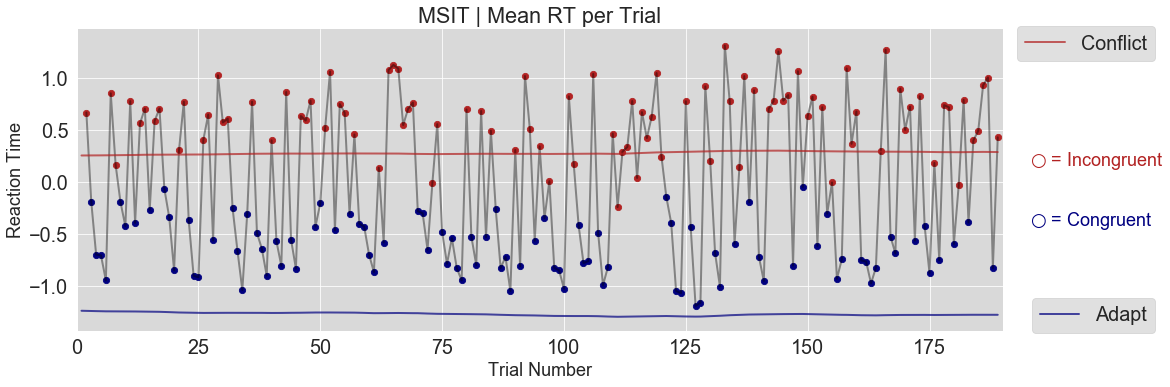

In [8]:
def ss_rt_plots(df_type,sub_or_group):
    ##---------------------------------##
    ## Plot SS and Behvaior
    ##---------------------------------##  
    plt.style.use('fivethirtyeight')
    sns.set_style("darkgrid",{"axes.facecolor":".85"})
    sns.set_context('paper', font_scale=2.25)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Plot reaction time and trial timeseries
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    fig = plt.figure(figsize=(20,7))
    ax = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
    ss_title="MSIT | %s" % sub_or_group
    colors = np.where(df_type["cond"], 'firebrick', 'navy')
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Use when plotting indivs or groups (not averages)
#     markers = np.where(df_type["acc"],'o','x').squeeze()
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ax.plot(df_type["trial"], df_type["rt"], color='k', linewidth=2, alpha=0.4)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    for x,y,c in zip(df_type['trial'], df_type["rt"], colors): 
        ax.scatter(x,y,s=40,color=c)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Use when plotting indivs or groups (not averages)
#     for x,y,c,m in zip(df_type['trial'], df_type["rt"], colors, markers): 
#         ax.scatter(x,y,s=40,marker=m,color=c)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    for color, label in zip(['navy', 'firebrick'], ['C','I']): 
        ax.scatter([],[], s=60, color=color, label=label)
    # Configure matplotlib.patch.Patch properties
    props = dict(facecolor='white',alpha=0.5)
    ax.text(1.03, 0.6, r'$\bigcirc$ = Incongruent', transform=ax.transAxes, fontsize=18,\
        verticalalignment='top', bbox=props, color='firebrick')
    ax.text(1.03, 0.4, r'$\bigcirc$ = Congruent', transform=ax.transAxes, fontsize=18,\
        verticalalignment='top', bbox=props, color='navy')
    ax.set_xlim(0,190)
    ax.set_xlabel('Trial Number', fontsize=18)
    ax.set_ylabel('Reaction Time', fontsize=18)
    ax.set_title('%s' % ss_title,loc='center')
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Plot state space
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    line1,=ax.plot(df_type["trial"],df_type["conflict"],linewidth=2,alpha=0.7,color='firebrick',label='Conflict')
    line2,=ax.plot(df_type["trial"],df_type["adapt"],linewidth=2,alpha=0.7,color='navy',label='Adapt')
#     Conflict legend
    first_legend = plt.legend(handles=[line1],loc=7, bbox_to_anchor=(1.175,0.95))
    ax = plt.gca().add_artist(first_legend)
#     Adaptation legend
    plt.legend(handles=[line2],loc=7, bbox_to_anchor=(1.175, 0.05))
    sns.despine()
    plt.show() 
    return

ss_rt_plots(df_avg,'Mean RT per Trial')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     ss_rt_plots(df_sub,subj.upper())

In [ ]:
def ss_roi_plots(df_type,sub_or_group):
    for region in ['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']:
        ##---------------------------------##
        ## Plot SS and Behvaior
        ##---------------------------------##  
        plt.style.use('fivethirtyeight')
        sns.set_style("darkgrid",{"axes.facecolor":".65"})
        sns.set_context('paper', font_scale=2.25)
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ## Plot reaction time and trial timeseries
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        fig = plt.figure(figsize=(20,7))
        ax = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ss_title="%s | %s" % (sub_or_group,region)
        colors = np.where(df_type["cond"], 'firebrick', 'navy')
#         colors2 = np.where(df_type["cond"], 'k', 'y')
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ## Use when plotting indivs or groups (not averages)
#         markers = np.where(df_type["acc"],'o','x').squeeze()
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ax.plot(df_type['trial'], df_type['rt'], color='w',linewidth=3, alpha=0.4,linestyle="dashed")
        ax.plot(df_type['trial'], df_type['%s' % region], color='k', linewidth=2, alpha=0.4)
#         for x,y,c,m in zip(df_type['trial'], df_type['%s' % region], colors, markers):
#             ax.scatter(x,y,s=40,marker=m,color=c)
#         for x,y,c,m in zip(df_type['trial'], df_type['rt'], colors, markers):
#             ax.scatter(x,y,s=40,marker=m,color=c)
        for x,y,c in zip(df_type['trial'], df_type['rt'], colors):
            ax.scatter(x,y,s=40,color=c,marker="^")
        for x,y,c in zip(df_type['trial'], df_type['%s' % region], colors):
            ax.scatter(x,y,s=40,color=c,marker='o')
        for color, label in zip(['navy', 'firebrick'], ['C','I']): 
            ax.scatter([],[], s=60, color=color, label=label)
        # Configure matplotlib.patch.Patch properties
        props = dict(facecolor='white',alpha=0.5)
        ax.text(1.03, 0.6, r'$\bigcirc \bigtriangleup$ = Incongruent', transform=ax.transAxes, fontsize=18,\
            verticalalignment='top', bbox=props, color='firebrick')
        ax.text(1.03, 0.4, r'$\bigcirc \bigtriangleup$ = Congruent', transform=ax.transAxes, fontsize=18,\
            verticalalignment='top', bbox=props, color='navy')
        ##ax.text(1.03, 0.5, r'$\bullet$ = $\beta$', transform=ax.transAxes, fontsize=18,\
            ##verticalalignment='top', bbox=props, color='gold')
        ax.set_xlim(0,190)
        ax.set_xlabel('Trial Number', fontsize=18)
        ax.set_ylabel(r'ROI $\beta$ & Reaction Time', fontsize=18)
        ax.set_title('MSIT | %s' % ss_title,loc='center')
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ## Plot state space
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        line1,=ax.plot(df_type["trial"],df_type["conflict"],linewidth=2,alpha=0.7,color='firebrick',label='Conflict')
        line2,=ax.plot(df_type["trial"],df_type["adapt"],linewidth=2,alpha=0.7,color='navy',label='Adapt')
        ## Conflict legend
        first_legend = plt.legend(handles=[line1],loc=7, bbox_to_anchor=(1.175,0.95))
        ax = plt.gca().add_artist(first_legend)
        ## Adaptation legend
        plt.legend(handles=[line2],loc=7, bbox_to_anchor=(1.175, 0.05))
        sns.despine()
        plt.show() 
    return
# ss_rt_plots(df_avg,'hc')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     ss_roi_plots(df_sub,subj.upper())

### Visualize Beta Series Method Timeseries

In [25]:
def timeseries_plots(df_type,sub_or_group):
    plt.style.use('fivethirtyeight')
    sns.set_style("darkgrid",{"axes.facecolor":".85"})
    ##---------------------------------##
    ##  Display fMRI time-series
    ##---------------------------------##  
    df_rois = df_type[['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']].copy()
    df_rois.plot(subplots=True,figsize=(15, 6),fontsize=12,legend='right',linewidth=2)
    plt.xlabel("%s" % sub_or_group)
    plt.show()
    
    df_vars = df_type[['conflict','adapt','rt']].copy()
    df_vars.plot(subplots=True,figsize=(15, 6),fontsize=12,legend='right',linewidth=2)
    plt.xlabel("%s" % sub_or_group)
    plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# timeseries_plots(df_hcs_avg,'AVG ALL CONTROL SUBJS')
# timeseries_plots(df_pts_avg,'AVG ALL PSYCHIATRIC SUBJS')
# timeseries_plots(df_avg,'AVG ALL SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     timeseries_plots(df_sub,subj.upper())

### Distribution of ITIs

In [ ]:
ITIs=[]
subjects = ['hc001']
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
stim_blocks_path=os.path.join(raw_behav_dir,'stimuli_block.txt')
stim_blocks=pd.read_csv(stim_blocks_path,names=['sequence'])

rank_path=os.path.join(raw_behav_dir,'rank.txt')
rank=pd.read_csv(rank_path,names=['rank'])

for s in subjects:
    bcsv=glob.glob(os.path.join(raw_behav_dir,'%s*' % s))
    for file in bcsv:
        b=pd.read_csv(file)
        b['sequence'] = stim_blocks
        b['rank'] = rank
        for d,st in zip(b['Duration'],b['Stimuli']):
            if st=='+':
                ITIs.append(d)
            else:
                ITIs.append('0')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#         
def plot_ITIs(ISI):           
    sns.set()
    plt.subplots(figsize=(5,10))
    c=pd.DataFrame()
    c['ITIs']=ISI
    ax=sns.countplot(c['ITIs'],linewidth=5,facecolor=(0, 0, 0, 0),\
                  edgecolor=sns.color_palette("Set2", 3),\
                  order = c['ITIs'].value_counts().index)
    for p in ax.patches:
            ax.annotate('   {:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+2))
    plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# plot_ITIs(ITIs)

### Test sequence rank

In [ ]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
stim_blocks_path=os.path.join(raw_behav_dir,'stimuli_block.txt')
stim_blocks=pd.read_csv(stim_blocks_path,names=['sequence'])

rank_path=os.path.join(raw_behav_dir,'rank.txt')
rank=pd.read_csv(rank_path,names=['rank'])
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
for s in subjects:
    bcsv=glob.glob(os.path.join(raw_behav_dir,'%s*' % s))
    for file in bcsv:
        rt=[]
        dACC=[]
        L_IFG=[]
        R_IFG=[]
        L_dlPFC=[]
        R_dlPFC=[]
        censor=[]
        b=pd.read_csv(file)
        b['sequence'] = stim_blocks
        b['rank'] = rank 
        trials = b[ b['Stimuli'] != '+' ]
        trials=trials[1:-2]
        #---------------------------------##
        file_1=os.path.join(LSS_dir,'%s.dACC_LSS_avg_file.1D' % s)
        file_2=os.path.join(LSS_dir,'%s.L_IFG_LSS_avg_file.1D' % s)
        file_3=os.path.join(LSS_dir,'%s.R_IFG_LSS_avg_file.1D' % s)
        file_4=os.path.join(LSS_dir,'%s.L_dlPFC_LSS_avg_file.1D' % s)
        file_5=os.path.join(LSS_dir,'%s.R_dlPFC_LSS_avg_file.1D' % s)
        file_6=os.path.join(censor_dir,'msit.%s.msit_bsm.censor.1D' % s)
        #---------------------------------##
        ## Generate ROI variables
        generate_roi_vars(file_1,dACC,"dACC")
        generate_roi_vars(file_2,L_IFG,"L_IFG")
        generate_roi_vars(file_3,R_IFG,"R_IFG")
        generate_roi_vars(file_4,L_dlPFC,"L_dlPFC")
        generate_roi_vars(file_5,R_dlPFC,"R_dlPFC")
        censor_tps(file_6,censor,"censor")
        #---------------------------------## 
        ## Interpolate missing ROI + RT data points
        dACC = pd.Series(dACC).astype(float).interpolate()
        R_IFG = pd.Series(R_IFG).astype(float).interpolate()
        L_IFG = pd.Series(L_IFG).astype(float).interpolate()
        L_dlPFC = pd.Series(L_dlPFC).astype(float).interpolate()
        R_dlPFC = pd.Series(R_dlPFC).astype(float).interpolate()
        #---------------------------------##
        trials_df=pd.DataFrame({'dACC':dACC,'L_IFG':L_IFG,'R_IFG':R_IFG,\
                                'L_dlPFC':L_dlPFC,'R_dlPFC':R_dlPFC,\
                                'sequence':trials['sequence'],'rank':trials['rank'],\
                                'cond':trials['Condition']}) 
        # trials_df=trials_df.reset_index(drop=True)
        
        ROIs=['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']
        for roi in ROIs:
            sns.set()
            ax=sns.lmplot(data=trials_df,x='rank',y='%s' % roi,hue='cond',markers=['o','x'])
            plt.savefig(os.path.join(raw_behav_dir,'figs/%s.%s.conds.png' % (s,roi)))
            ax.set(xlim=(0,18),xticks=range(1,18))
            plt.title('%s' % s)
            ax=sns.lmplot(data=trials_df,x='rank',y='%s' % roi)
            ax.set(xlim=(0,18),xticks=range(1,18))
            plt.title('%s' % s)
            plt.savefig(os.path.join(raw_behav_dir,'figs/%s.%s.png' % (s,roi)))
            plt.show() 